# **Projet Apprentissage Machine : Analyse de performance académique (Student Performance Dataset – Kaggle)**

<u>Objectif :</u>
1. Régression pour prédire les notes finales.
2. Classification (succès vs échec).
3. Clustering des profils d'étudiants.
4. Ensembles pour combiner les prédictions.

### **Description du jeu de données :**
Ce jeu de données contient les notes des étudiants au Lycée (États-Unis) pour certaines matières, et l'influence du bagage parental sur les performances académiques.

- gender : (female, male)
- race/ethnicity : (group C, group D, group B, group E, group A)
- parental level of education : (some college, associate's degree, high school, some high school, bachelor's degree, master's degree)
- lunch : (standard, free/reduced)
- test preparation course : (none, completed)
- math score : (Entre 0 et 100)
- reading score : (Entre 17 et 100)
- writing score : (Entre 10 et 100)

# 1.  **Chargement et préparation des données**
<u>Tâches à faire</u> :
1. Nettoyage, encodage des variables catégorielles, normalisation.
2. Gestion des valeurs manquantes.
3. Analyse descriptive des données.

### **(a) Importation des bibliothèques**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import random
import os

from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             mean_squared_error, r2_score, confusion_matrix, classification_report,
                             silhouette_score, calinski_harabasz_score, davies_bouldin_score)

# Pour un meilleur affichage des graphiques
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Reproducibilité
SEED = 42
random.seed(SEED)
np.random.seed(seed=SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

### **(b) Chargement des données**

In [4]:
# Chargement des données
df = pd.read_csv("../data/StudentsPerformance.csv")
print(f"Taille du dataset : {df.shape}")
df.head()

Taille du dataset : (1000, 8)


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


### **(c) Nettoyage des données**

In [5]:
# Informations générales
print("=== Informations sur le dataset ===")
df.info()
print("\n" + "="*50)

=== Informations sur le dataset ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB



In [6]:
# Vérification des valeurs manquantes
print("\n=== Valeurs manquantes ===")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])
print("Aucune valeur manquante" if missing_values.sum() == 0 else "Valeurs manquantes détectées")


=== Valeurs manquantes ===
Series([], dtype: int64)
Aucune valeur manquante


In [7]:
# Vérification des doublons
print("\n=== Doublons ===")
duplicates = df.duplicated().sum()
print(f"Nombre de doublons : {duplicates}")
if duplicates > 0:
    df = df.drop_duplicates()
    print(f"Doublons supprimés. Nouvelle taille : {df.shape}")


=== Doublons ===
Nombre de doublons : 0


In [8]:
# Statistiques descriptives
print("\n=== Statistiques descriptives (variables numériques) ===")
print(df.describe())


=== Statistiques descriptives (variables numériques) ===
       math score  reading score  writing score
count  1000.00000    1000.000000    1000.000000
mean     66.08900      69.169000      68.054000
std      15.16308      14.600192      15.195657
min       0.00000      17.000000      10.000000
25%      57.00000      59.000000      57.750000
50%      66.00000      70.000000      69.000000
75%      77.00000      79.000000      79.000000
max     100.00000     100.000000     100.000000


In [9]:
# Statistiques descriptives (variables catégorielles)
print("\n=== Statistiques descriptives (variables catégorielles) ===")
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f"\n{col}:")
    print(df[col].value_counts())
    print(f"Nombre de catégories : {df[col].nunique()}")


=== Statistiques descriptives (variables catégorielles) ===

gender:
gender
female    518
male      482
Name: count, dtype: int64
Nombre de catégories : 2

race/ethnicity:
race/ethnicity
group C    319
group D    262
group B    190
group E    140
group A     89
Name: count, dtype: int64
Nombre de catégories : 5

parental level of education:
parental level of education
some college          226
associate's degree    222
high school           196
some high school      179
bachelor's degree     118
master's degree        59
Name: count, dtype: int64
Nombre de catégories : 6

lunch:
lunch
standard        645
free/reduced    355
Name: count, dtype: int64
Nombre de catégories : 2

test preparation course:
test preparation course
none         642
completed    358
Name: count, dtype: int64
Nombre de catégories : 2


### **(d) Création de variables cibles**
- Classification
- Régression

In [10]:
# Création de variables cibles pour les différents objectifs

# Note moyenne pour la régression
df['average_score'] = df[['math score', 'reading score', 'writing score']].mean(axis=1)

In [11]:
# Succès/Échec pour la classification (seuil à 70% de la moyenne)
df['success'] = (df['average_score'] >= 70).astype(int)

In [12]:
# Catégorie de performance (A, B, C, D, F) basée sur la note moyenne
def get_grade(score):
    if score >= 90:
        return 'A'
    elif score >= 80:
        return 'B'
    elif score >= 70:
        return 'C'
    elif score >= 60:
        return 'D'
    else:
        return 'F'

df['grade'] = df['average_score'].apply(get_grade)

In [13]:
print("=== Distribution des nouvelles variables ===")
print(f"\nNote moyenne (average_score):")
print(df['average_score'].describe())

=== Distribution des nouvelles variables ===

Note moyenne (average_score):
count    1000.000000
mean       67.770667
std        14.257326
min         9.000000
25%        58.333333
50%        68.333333
75%        77.666667
max       100.000000
Name: average_score, dtype: float64


In [14]:
print(f"\nSuccès (>=60): 1, échec (<60): 0")
print(df['success'].value_counts())
print(f"Taux de succès : {(df['success'].sum() / len(df) * 100):.2f}%")


Succès (>=60): 1, échec (<60): 0
success
0    541
1    459
Name: count, dtype: int64
Taux de succès : 45.90%


In [15]:
print(f"\nGrade (catégorie de performance):")
print(df['grade'].value_counts().sort_index())


Grade (catégorie de performance):
grade
A     52
B    146
C    261
D    256
F    285
Name: count, dtype: int64


### **(e) Encodage des variables catégorielles**

In [16]:
# Création d'une copie pour l'encodage
df_encoded = df.copy()

In [17]:
# One-Hot Encoding pour les variables nominales sans ordre naturel
# 'gender', 'lunch', 'test preparation course'
df_encoded = pd.get_dummies(df_encoded, columns=['gender', 'lunch', 'test preparation course'], 
                           drop_first=True)  # Éviter la multicolinéarité

In [18]:
# Encodage ordinal pour 'parental level of education' (ordre éducatif)
education_order = ["some high school", "high school", "some college", 
                   "associate's degree", "bachelor's degree", "master's degree"]

In [19]:
# Création d'un dictionnaire de mapping
education_mapping = {level: i for i, level in enumerate(education_order)}
print("Mapping pour l'encodage ordinal (parental level of education):")
for level, code in education_mapping.items():
    print(f"  {level} : {code}")

Mapping pour l'encodage ordinal (parental level of education):
  some high school : 0
  high school : 1
  some college : 2
  associate's degree : 3
  bachelor's degree : 4
  master's degree : 5


In [20]:
# Application du mapping
df_encoded['parental level of education'] = df_encoded['parental level of education'
                                                       ].map(education_mapping)

In [21]:
# Encodage de fréquence pour 'race/ethnicity' (représente la proportion)
freq_encoding = df_encoded['race/ethnicity'].value_counts(normalize=True)
print("\nEncodage de fréquence pour race/ethnicity:")
for group, freq in freq_encoding.items():
    print(f"  {group} : {freq:.3f}")

df_encoded['race/ethnicity_freq'] = df_encoded['race/ethnicity'].map(freq_encoding)
df_encoded = df_encoded.drop('race/ethnicity', axis=1)


Encodage de fréquence pour race/ethnicity:
  group C : 0.319
  group D : 0.262
  group B : 0.190
  group E : 0.140
  group A : 0.089


In [22]:
# Label Encoding pour 'grade' (catégorie ordinale)
grade_order = ['F', 'D', 'C', 'B', 'A']
grade_mapping = {grade: i for i, grade in enumerate(grade_order)}
df_encoded['grade_encoded'] = df_encoded['grade'].map(grade_mapping)
df_encoded = df_encoded.drop('grade', axis=1)

In [23]:
print(f"\n=== Dataset après encodage ===")
print(f"Taille : {df_encoded.shape}")
print(f"Colonnes : {list(df_encoded.columns)}")
df_encoded.head()


=== Dataset après encodage ===
Taille : (1000, 11)
Colonnes : ['parental level of education', 'math score', 'reading score', 'writing score', 'average_score', 'success', 'gender_male', 'lunch_standard', 'test preparation course_none', 'race/ethnicity_freq', 'grade_encoded']


,parental level of education,math score,reading score,writing score,average_score,success,gender_male,lunch_standard,test preparation course_none,race/ethnicity_freq,grade_encoded
0,4,72,72,74,72.666667,1,False,True,True,0.190,2
1,2,69,90,88,82.333333,1,False,True,False,0.319,3
2,5,90,95,93,92.666667,1,False,True,True,0.190,4
3,3,47,57,44,49.333333,0,True,False,True,0.089,0
4,2,76,78,75,76.333333,1,True,True,True,0.319,2


### **(f) Normalisation/Standardisation des données**

In [24]:
# Séparation des features et des targets
# Features à exclure (variables cibles et identifiantes)
targets = ['average_score', 'success', 'math score', 'reading score', 'writing score', 'grade_encoded']

# Features pour la modélisation
features = [col for col in df_encoded.columns if col not in targets]

print(f"Nombre de features : {len(features)}")
print(f"Features : {features}")

Nombre de features : 5
Features : ['parental level of education', 'gender_male', 'lunch_standard', 'test preparation course_none', 'race/ethnicity_freq']


In [25]:
# Création des ensembles de données
X = df_encoded[features]  # Features
y_reg = df_encoded['average_score']  # Cible pour régression
y_class = df_encoded['success']  # Cible pour classification
y_grade = df_encoded['grade_encoded']  # Cible pour classification multi-classe

In [26]:
print(f"\n=== Dimensions des datasets ===")
print(f"X (features) : {X.shape}")
print(f"y_reg (régression) : {y_reg.shape}")
print(f"y_class (classification binaire) : {y_class.shape}")
print(f"y_grade (classification multi-classe) : {y_grade.shape}")


=== Dimensions des datasets ===
X (features) : (1000, 5)
y_reg (régression) : (1000,)
y_class (classification binaire) : (1000,)
y_grade (classification multi-classe) : (1000,)


In [27]:
# Normalisation avec MinMaxScaler (à but de comparaison)
print("\n=== Normalisation avec MinMaxScaler ===")
minmax_scaler = MinMaxScaler()
X_minmax = minmax_scaler.fit_transform(X)
X_minmax = pd.DataFrame(X_minmax, columns=features, index=X.index)

print("Aperçu des données normalisées (MinMaxScaler):")
print(X_minmax.head())
print(f"\nPlage des valeurs : [{X_minmax.min().min():.3f}, {X_minmax.max().max():.3f}]")


=== Normalisation avec MinMaxScaler ===
Aperçu des données normalisées (MinMaxScaler):
   parental level of education  gender_male  lunch_standard  \
0                          0.8          0.0             1.0   
1                          0.4          0.0             1.0   
2                          1.0          0.0             1.0   
3                          0.6          1.0             0.0   
4                          0.4          1.0             1.0   

   test preparation course_none  race/ethnicity_freq  
0                           1.0              0.43913  
1                           0.0              1.00000  
2                           1.0              0.43913  
3                           1.0              0.00000  
4                           1.0              1.00000  

Plage des valeurs : [0.000, 1.000]


In [28]:
# Standardisation avec StandardScaler (à but de comparaison)
print("\n=== Standardisation avec StandardScaler ===")
std_scaler = StandardScaler()
X_std = std_scaler.fit_transform(X)
X_std = pd.DataFrame(X_std, columns=features, index=X.index)

print("Aperçu des données standardisées (StandardScaler):")
print(X_std.head())
print(f"\nMoyenne des features : {X_std.mean().mean():.3f}")
print(f"Écart-type des features : {X_std.std().mean():.3f}")

# Nous utiliserons X_std (standardisé) pour la suite car souvent mieux pour les modèles linéaires


=== Standardisation avec StandardScaler ===
Aperçu des données standardisées (StandardScaler):
   parental level of education  gender_male  lunch_standard  \
0                     1.314742    -0.964625        0.741881   
1                    -0.055495    -0.964625        0.741881   
2                     1.999860    -0.964625        0.741881   
3                     0.629624     1.036672       -1.347925   
4                    -0.055495     1.036672        0.741881   

   test preparation course_none  race/ethnicity_freq  
0                      0.746748            -0.569024  
1                     -1.339140             1.098265  
2                      0.746748            -0.569024  
3                      0.746748            -1.874421  
4                      0.746748             1.098265  

Moyenne des features : -0.000
Écart-type des features : 1.001


### **(g) Séparation des données en ensembles d'entraînement et de test**

In [29]:
# Séparation pour la classification binaire (success)
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X_std, y_class, test_size=0.25, random_state=42, stratify=y_class
)

# Séparation pour la régression (average_score)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_std, y_reg, test_size=0.25, random_state=42
)

# Séparation pour la classification multi-classe (grade)
X_train_grade, X_test_grade, y_train_grade, y_test_grade = train_test_split(
    X_std, y_grade, test_size=0.25, random_state=42, stratify=y_grade
)

In [30]:
print("=== Répartition des ensembles d'entraînement et de test ===")
print(f"\n1. Classification binaire (Basé sur la colonne success):")
print(f"   Train : {X_train_class.shape[0]} échantillons")
print(f"   Test  : {X_test_class.shape[0]} échantillons")
print(f"   Distribution dans train : {y_train_class.value_counts().to_dict()}")
print(f"   Distribution dans test  : {y_test_class.value_counts().to_dict()}")

=== Répartition des ensembles d'entraînement et de test ===

1. Classification binaire (Basé sur la colonne success):
   Train : 750 échantillons
   Test  : 250 échantillons
   Distribution dans train : {0: 406, 1: 344}
   Distribution dans test  : {0: 135, 1: 115}


In [31]:
print(f"\n2. Régression - (basé sur le `average_score` des notes):")
print(f"   Train : {X_train_reg.shape[0]} échantillons")
print(f"   Test  : {X_test_reg.shape[0]} échantillons")
print(f"   Moyenne dans train : {y_train_reg.mean():.2f}")
print(f"   Moyenne dans test  : {y_test_reg.mean():.2f}")


2. Régression - (basé sur le `average_score` des notes):
   Train : 750 échantillons
   Test  : 250 échantillons
   Moyenne dans train : 68.34
   Moyenne dans test  : 66.05


In [32]:
print(f"\n3. Classification multi-classe (Basé sur le grade):")
print(f"   Train : {X_train_grade.shape[0]} échantillons")
print(f"   Test  : {X_test_grade.shape[0]} échantillons")
print(f"   Distribution dans train :")
for grade_code, grade_name in enumerate(grade_order):
    count = (y_train_grade == grade_code).sum()
    print(f"     {grade_name} ({grade_code}) : {count} échantillons")


3. Classification multi-classe (Basé sur le grade):
   Train : 750 échantillons
   Test  : 250 échantillons
   Distribution dans train :
     F (0) : 214 échantillons
     D (1) : 192 échantillons
     C (2) : 196 échantillons
     B (3) : 109 échantillons
     A (4) : 39 échantillons


# **2. Analyse exploratoire et visualisation**

<u>Tâches à faire</u> :
- Visualisations des distributions et corrélations.
- Graphiques par classes, regroupements, ou tendances temporelles.

### **(a) Distribution des scores**

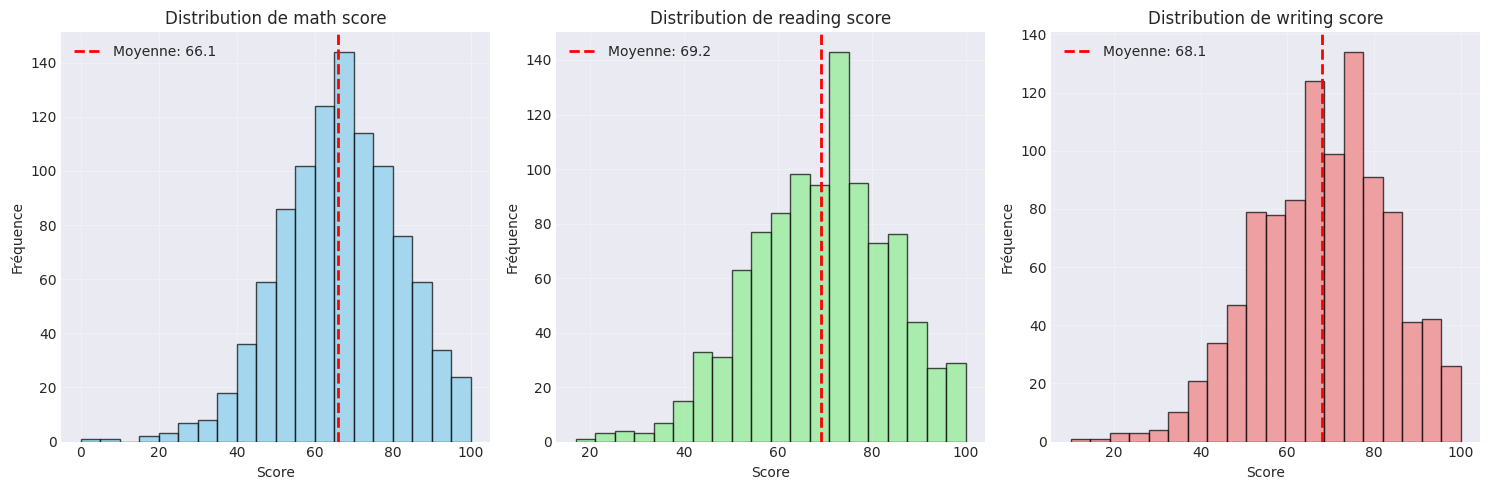

In [33]:
# Distribution des scores individuels
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

scores = ['math score', 'reading score', 'writing score']
colors = ['skyblue', 'lightgreen', 'lightcoral']

for idx, (score, color) in enumerate(zip(scores, colors)):
    axes[idx].hist(df[score], bins=20, color=color, edgecolor='black', alpha=0.7)
    axes[idx].axvline(df[score].mean(), color='red', linestyle='--', linewidth=2, 
                     label=f'Moyenne: {df[score].mean():.1f}')
    axes[idx].set_title(f'Distribution de {score}')
    axes[idx].set_xlabel('Score')
    axes[idx].set_ylabel('Fréquence')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

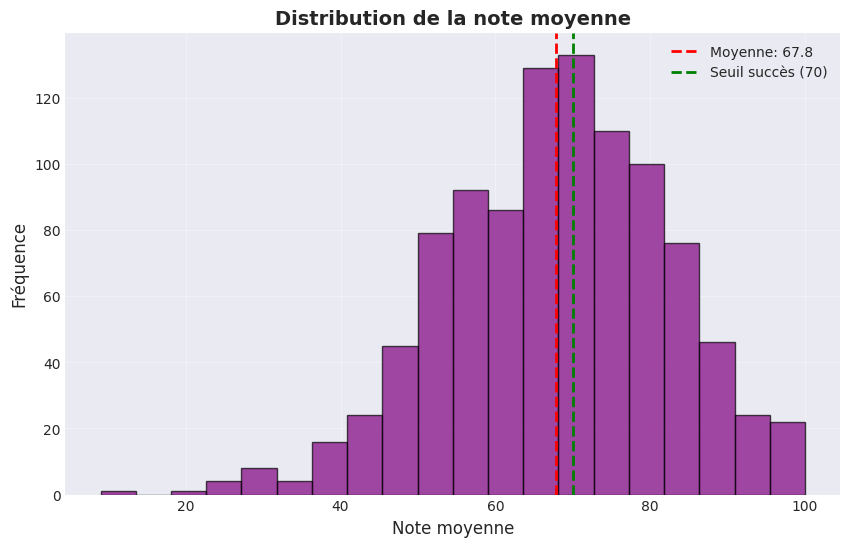

In [34]:
# Distribution de la note moyenne
plt.figure(figsize=(10, 6))
plt.hist(df['average_score'], bins=20, color='purple', edgecolor='black', alpha=0.7)
plt.axvline(df['average_score'].mean(), color='red', linestyle='--', linewidth=2, 
           label=f'Moyenne: {df["average_score"].mean():.1f}')
plt.axvline(70, color='green', linestyle='--', linewidth=2, label='Seuil succès (70)')
plt.title('Distribution de la note moyenne', fontsize=14, fontweight='bold')
plt.xlabel('Note moyenne', fontsize=12)
plt.ylabel('Fréquence', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### **(b) Analyse des variables catégorielles**

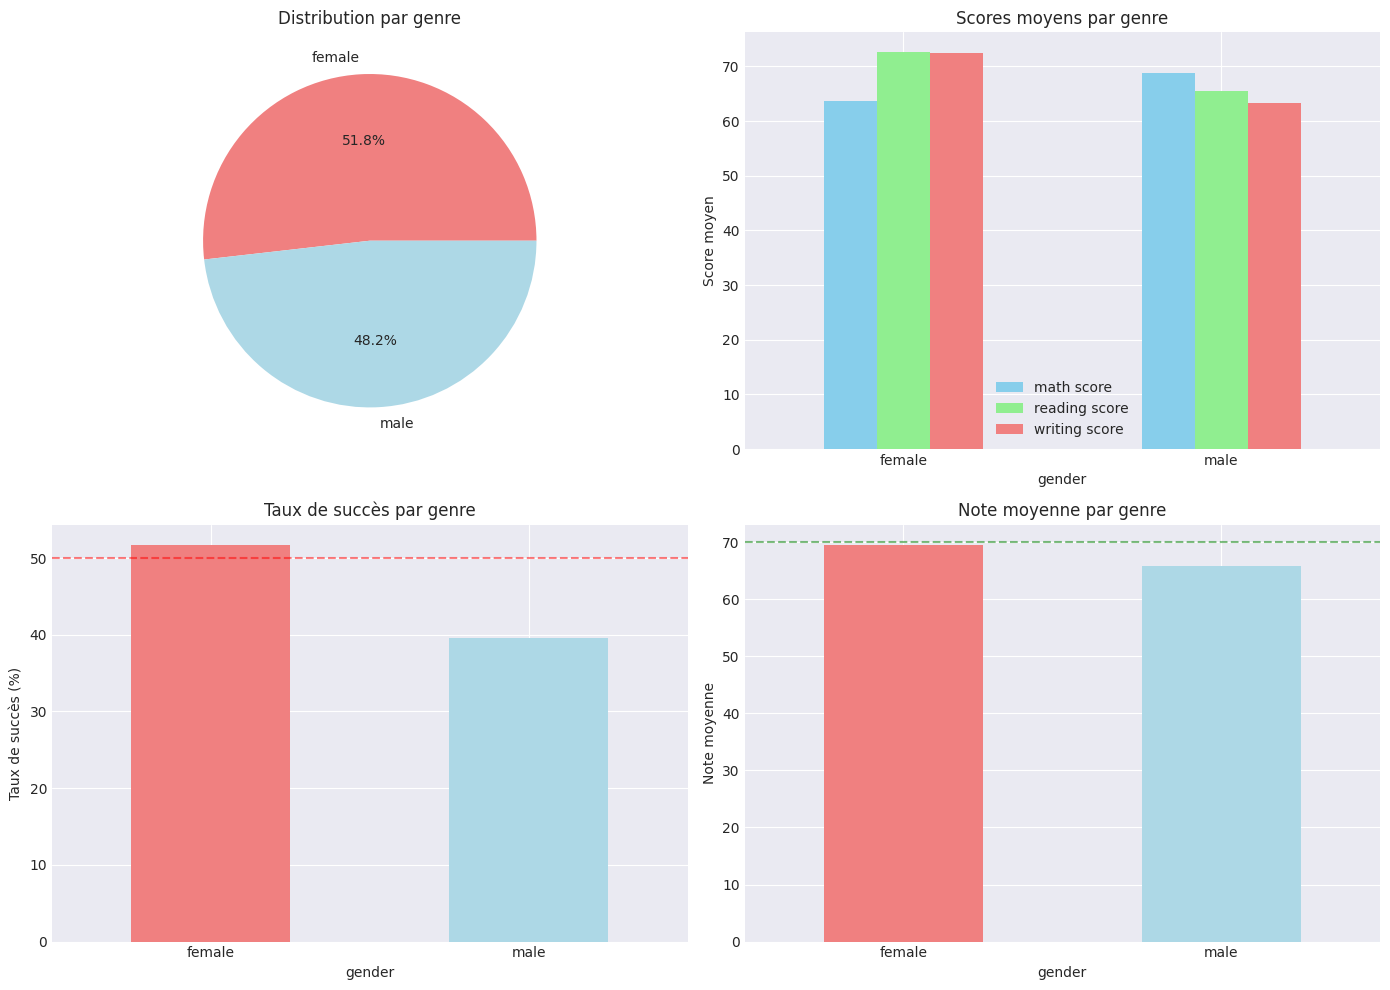

In [35]:
# Impact du genre sur les performances
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Distribution par genre
gender_counts = df['gender'].value_counts()
axes[0, 0].pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%',
               colors=['lightcoral', 'lightblue'])
axes[0, 0].set_title('Distribution par genre')

# Scores par genre
gender_scores = df.groupby('gender')[['math score', 'reading score', 'writing score']].mean()
gender_scores.plot(kind='bar', ax=axes[0, 1], color=['skyblue', 'lightgreen', 'lightcoral'])
axes[0, 1].set_title('Scores moyens par genre')
axes[0, 1].set_ylabel('Score moyen')
axes[0, 1].tick_params(axis='x', rotation=0)

# Taux de succès par genre
success_by_gender = df.groupby('gender')['success'].mean() * 100
success_by_gender.plot(kind='bar', ax=axes[1, 0], color=['lightcoral', 'lightblue'])
axes[1, 0].set_title('Taux de succès par genre')
axes[1, 0].set_ylabel('Taux de succès (%)')
axes[1, 0].tick_params(axis='x', rotation=0)
axes[1, 0].axhline(50, color='red', linestyle='--', alpha=0.5)

# Note moyenne par genre
avg_by_gender = df.groupby('gender')['average_score'].mean()
avg_by_gender.plot(kind='bar', ax=axes[1, 1], color=['lightcoral', 'lightblue'])
axes[1, 1].set_title('Note moyenne par genre')
axes[1, 1].set_ylabel('Note moyenne')
axes[1, 1].tick_params(axis='x', rotation=0)
axes[1, 1].axhline(70, color='green', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

### **(c) Impact du niveau d'éducation des parents**

/tmp/ipykernel_110370/2893074676.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_score_by_edu = df.groupby('parental level of education')['average_score'].mean()


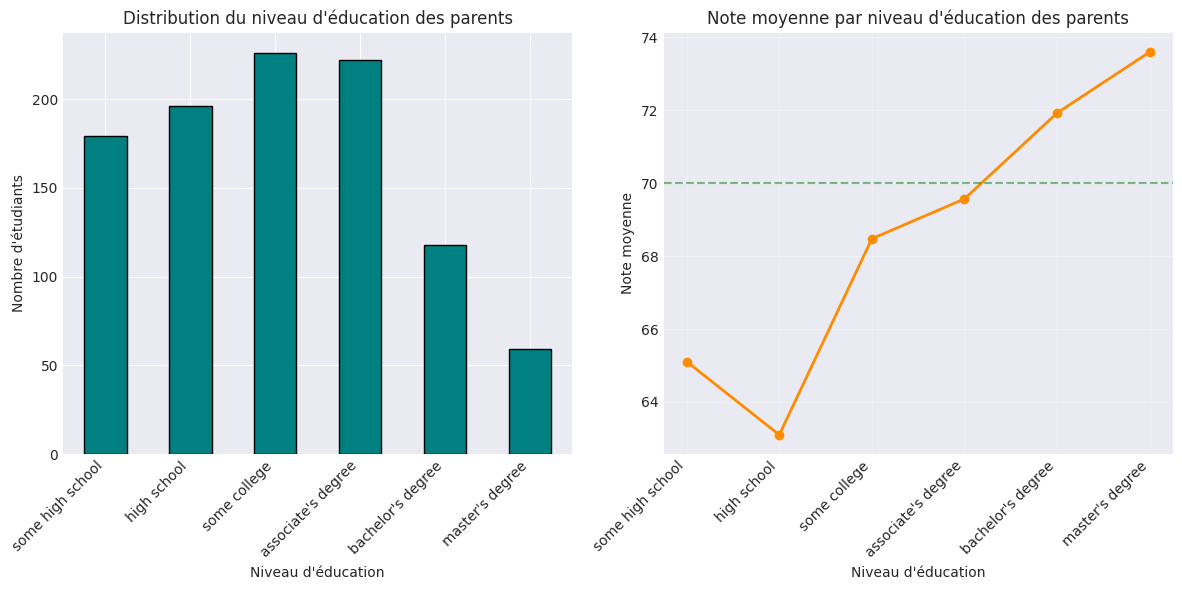

In [36]:
# Distribution du niveau d'éducation
plt.figure(figsize=(12, 6))

# Trier par ordre éducatif
education_order_viz = ["some high school", "high school", "some college", 
                       "associate's degree", "bachelor's degree", "master's degree"]
df['parental level of education'] = pd.Categorical(
    df['parental level of education'], categories=education_order_viz, ordered=True
)

# Graphique à barres
education_counts = df['parental level of education'].value_counts().sort_index()
plt.subplot(1, 2, 1)
education_counts.plot(kind='bar', color='teal', edgecolor='black')
plt.title('Distribution du niveau d\'éducation des parents')
plt.xlabel('Niveau d\'éducation')
plt.ylabel('Nombre d\'étudiants')
plt.xticks(rotation=45, ha='right')

# Impact sur la note moyenne
plt.subplot(1, 2, 2)
avg_score_by_edu = df.groupby('parental level of education')['average_score'].mean()
avg_score_by_edu.plot(kind='line', marker='o', color='darkorange', linewidth=2)
plt.title('Note moyenne par niveau d\'éducation des parents')
plt.xlabel('Niveau d\'éducation')
plt.ylabel('Note moyenne')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.axhline(70, color='green', linestyle='--', alpha=0.5, label='Seuil succès')

plt.tight_layout()
plt.show()

### **(d) Matrice de corrélation**

=== Corrélations avec les variables cibles ===

1. Corrélations avec average_score (régression):
   reading score                  : +0.970
   writing score                  : +0.966
   grade_encoded                  : +0.931
   math score                     : +0.919
   success                        : +0.793
   lunch_standard                 : +0.290
   parental level of education    : +0.206
   gender_male                    : -0.131
   test preparation course_none   : -0.257

2. Corrélations avec success (classification):
   grade_encoded                  : +0.867
   average_score                  : +0.793
   reading score                  : +0.776
   writing score                  : +0.764
   math score                     : +0.723
   lunch_standard                 : +0.222
   parental level of education    : +0.137
   gender_male                    : -0.121
   test preparation course_none   : -0.225


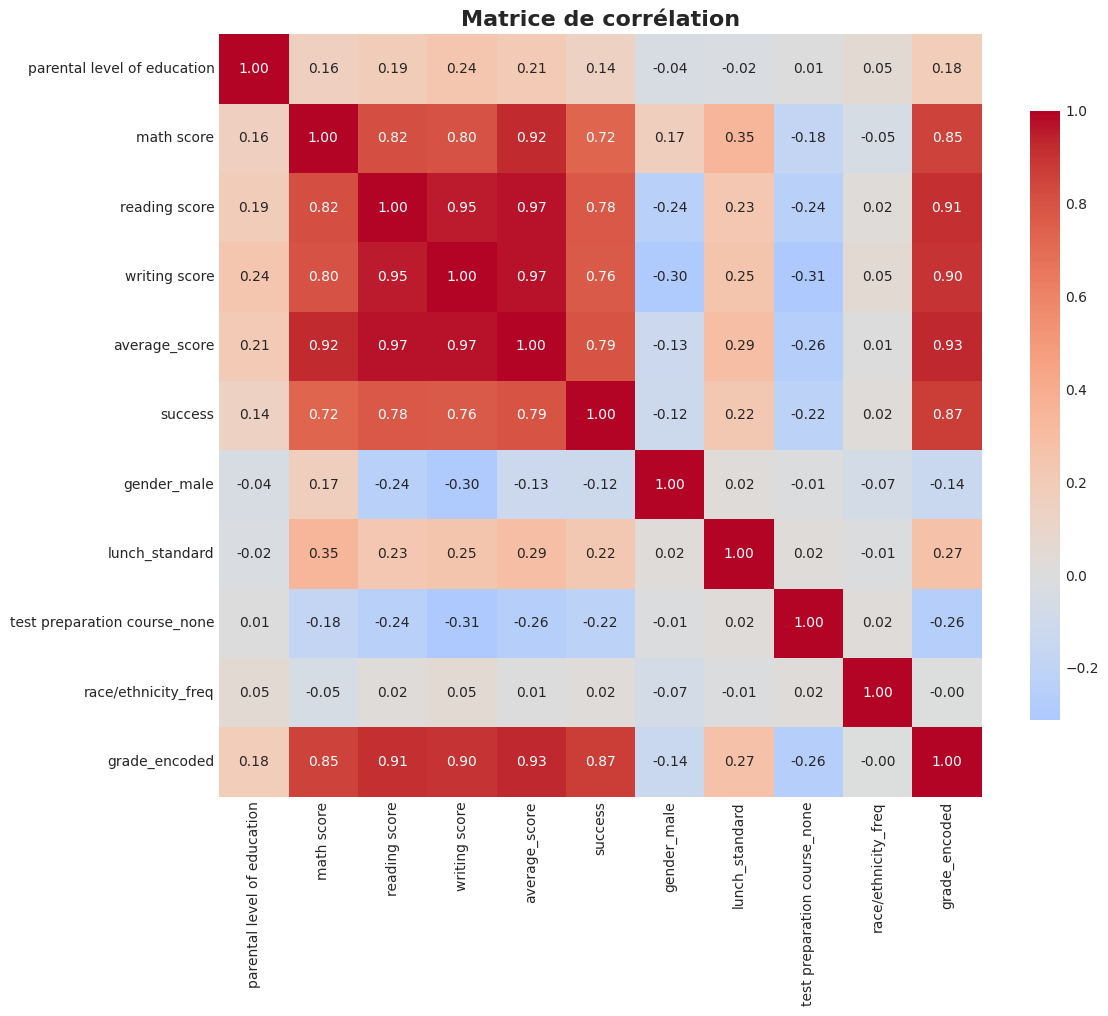

In [37]:
# Calcul de la matrice de corrélation
correlation_matrix = df_encoded.corr()

# Focus sur les corrélations avec les cibles
print("=== Corrélations avec les variables cibles ===")

print("\n1. Corrélations avec average_score (régression):")
corr_with_avg = correlation_matrix['average_score'].sort_values(ascending=False)
for feature, corr in corr_with_avg.items():
    if feature != 'average_score' and abs(corr) > 0.1:
        print(f"   {feature:30} : {corr:+.3f}")

print("\n2. Corrélations avec success (classification):")
corr_with_success = correlation_matrix['success'].sort_values(ascending=False)
for feature, corr in corr_with_success.items():
    if feature != 'success' and abs(corr) > 0.1:
        print(f"   {feature:30} : {corr:+.3f}")

# Visualisation de la matrice de corrélation
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, cbar_kws={"shrink": 0.8})
plt.title('Matrice de corrélation', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# **3. Modélisation supervisée**
<u>Tâches à faire</u> :
- Entraîner au moins deux modèles différents (>2).
- Comparer les performances avec validation croisée et métriques adaptées.

### **(a) Régression - Prédiction de la note moyenne**

In [38]:
# Imports
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error

In [39]:
# Initialisation des modèles de régression
# Hyperparamètres de base
reg_models = {
    'Régression Linéaire': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0, random_state=42),
    'Lasso Regression': Lasso(alpha=0.01, random_state=42),
    'Arbre de Décision': DecisionTreeRegressor(max_depth=5, random_state=42),
    'SVR': SVR(kernel='rbf', C=1.0)
}

In [40]:
# Entraînement et évaluation des modèles
reg_results = []

for name, model in reg_models.items():
    # Entraînement
    model.fit(X_train_reg, y_train_reg)
    
    # Prédictions
    y_pred_train = model.predict(X_train_reg)
    y_pred_test = model.predict(X_test_reg)
    
    # Calcul des métriques
    train_mse = mean_squared_error(y_train_reg, y_pred_train)
    test_mse = mean_squared_error(y_test_reg, y_pred_test)
    train_r2 = r2_score(y_train_reg, y_pred_train)
    test_r2 = r2_score(y_test_reg, y_pred_test)
    train_mae = mean_absolute_error(y_train_reg, y_pred_train)
    test_mae = mean_absolute_error(y_test_reg, y_pred_test)
    
    # Validation croisée
    # Métrique principale utilisé - 'r2'
    cv_scores = cross_val_score(model, X_std, y_reg, cv=5, scoring='r2')
    
    # Stockage des résultats
    reg_results.append({
        'Modèle': name,
        'Train MSE': train_mse,
        'Test MSE': test_mse,
        'Train R²': train_r2,
        'Test R²': test_r2,
        'Train MAE': train_mae,
        'Test MAE': test_mae,
        'CV R² Mean': cv_scores.mean(),
        'CV R² Std': cv_scores.std()
    })

In [41]:
# Création du DataFrame de résultats
reg_results_df = pd.DataFrame(reg_results)
print("=== Résultats des modèles de régression ===")
print(reg_results_df.round(4))

=== Résultats des modèles de régression ===
                Modèle  Train MSE  Test MSE  Train R²  Test R²  Train MAE  \
0  Régression Linéaire   152.5595  182.1208    0.2171   0.1860    10.0618   
1     Ridge Regression   152.5596  182.1265    0.2171   0.1859    10.0612   
2     Lasso Regression   152.5600  182.1241    0.2171   0.1859    10.0601   
3    Arbre de Décision   139.2558  198.0693    0.2854   0.1147     9.5618   
4                  SVR   152.9382  190.2309    0.2152   0.1497     9.9188   

   Test MAE  CV R² Mean  CV R² Std  
0   10.6250      0.1982     0.0458  
1   10.6252      0.1982     0.0457  
2   10.6246      0.1983     0.0456  
3   11.1871      0.1385     0.0555  
4   10.8136      0.1628     0.0367  


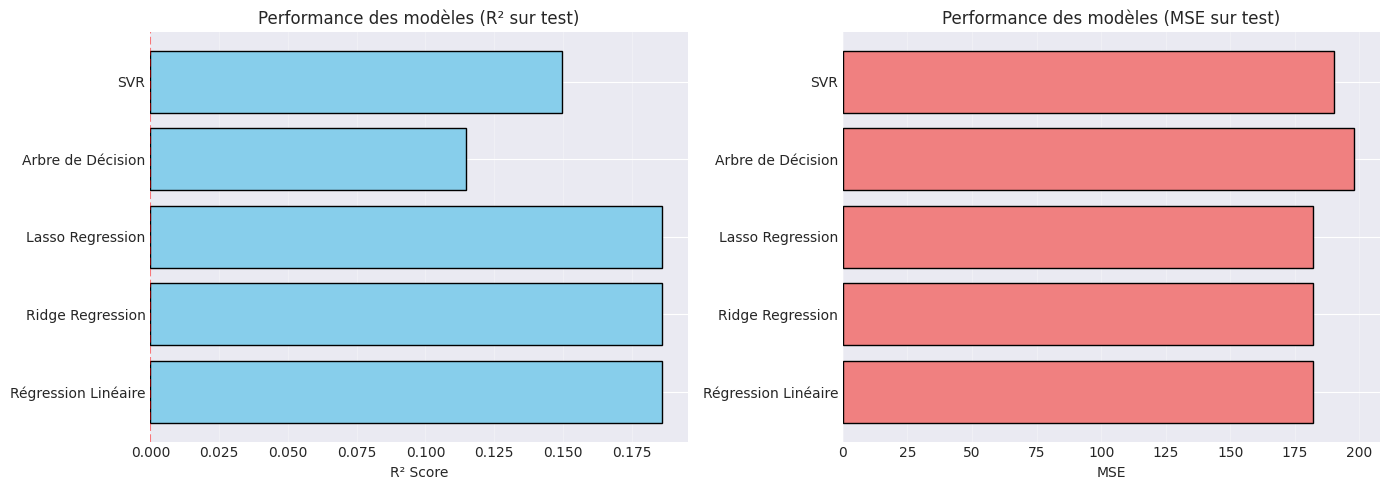

In [42]:
# Visualisation des performances
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# R² scores
axes[0].barh(reg_results_df['Modèle'], reg_results_df['Test R²'], color='skyblue', edgecolor='black')
axes[0].axvline(0, color='red', linestyle='--', alpha=0.5)
axes[0].set_xlabel('R² Score')
axes[0].set_title('Performance des modèles (R² sur test)')
axes[0].grid(True, alpha=0.3, axis='x')

# MSE scores
axes[1].barh(reg_results_df['Modèle'], reg_results_df['Test MSE'], color='lightcoral', edgecolor='black')
axes[1].set_xlabel('MSE')
axes[1].set_title('Performance des modèles (MSE sur test)')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

### **(b) Classification binaire - Prédiction du succès des étudiants**

In [43]:
# Imports
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, roc_curve

In [44]:
# Initialisation des modèles de classification
# Hyperparamètres de base
class_models = {
    'Régression Logistique': LogisticRegression(random_state=42, max_iter=1000),
    'Arbre de Décision': DecisionTreeClassifier(max_depth=5, random_state=42),
    'SVM Linéaire': SVC(kernel='linear', probability=True, random_state=42),
    'SVM RBF': SVC(kernel='rbf', probability=True, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

In [45]:
# Entraînement et évaluation des modèles
class_results = []

for name, model in class_models.items():
    # Entraînement
    model.fit(X_train_class, y_train_class)
    
    # Prédictions
    y_pred_train = model.predict(X_train_class)
    y_pred_test = model.predict(X_test_class)
    y_prob_test = model.predict_proba(X_test_class)[:, 1] if hasattr(model, 'predict_proba') else model.decision_function(X_test_class)
    
    # Calcul des métriques
    train_acc = accuracy_score(y_train_class, y_pred_train)
    test_acc = accuracy_score(y_test_class, y_pred_test)
    train_precision = precision_score(y_train_class, y_pred_train)
    test_precision = precision_score(y_test_class, y_pred_test)
    train_recall = recall_score(y_train_class, y_pred_train)
    test_recall = recall_score(y_test_class, y_pred_test)
    train_f1 = f1_score(y_train_class, y_pred_train)
    test_f1 = f1_score(y_test_class, y_pred_test)
    
    # AUC-ROC
    try:
        test_auc = roc_auc_score(y_test_class, y_prob_test)
    except:
        test_auc = np.nan
    
    # Validation croisée (accuracy)
    cv_scores = cross_val_score(model, X_std, y_class, cv=5, scoring='accuracy')
    
    # Stockage des résultats
    class_results.append({
        'Modèle': name,
        'Train Accuracy': train_acc,
        'Test Accuracy': test_acc,
        'Train Precision': train_precision,
        'Test Precision': test_precision,
        'Train Recall': train_recall,
        'Test Recall': test_recall,
        'Train F1': train_f1,
        'Test F1': test_f1,
        'Test AUC': test_auc,
        'CV Accuracy Mean': cv_scores.mean(),
        'CV Accuracy Std': cv_scores.std()
    })

In [46]:
# Création du DataFrame de résultats
class_results_df = pd.DataFrame(class_results)
print("=== Résultats des modèles de classification binaire ===")
print(class_results_df.round(4))

=== Résultats des modèles de classification binaire ===
                  Modèle  Train Accuracy  Test Accuracy  Train Precision  \
0  Régression Logistique          0.6533          0.676           0.6382   
1      Arbre de Décision          0.6880          0.612           0.6871   
2           SVM Linéaire          0.6307          0.584           0.6284   
3                SVM RBF          0.6640          0.608           0.6544   
4                    KNN          0.7133          0.596           0.6817   

   Test Precision  Train Recall  Test Recall  Train F1  Test F1  Test AUC  \
0          0.6604        0.5640       0.6087    0.5988   0.6335    0.7289   
1          0.5900        0.5872       0.5130    0.6332   0.5488    0.6689   
2          0.5567        0.4767       0.4696    0.5421   0.5094    0.6781   
3          0.5794        0.5669       0.5391    0.6075   0.5586    0.6656   
4          0.5625        0.7035       0.5478    0.6924   0.5551    0.6447   

   CV Accuracy Mean  CV 

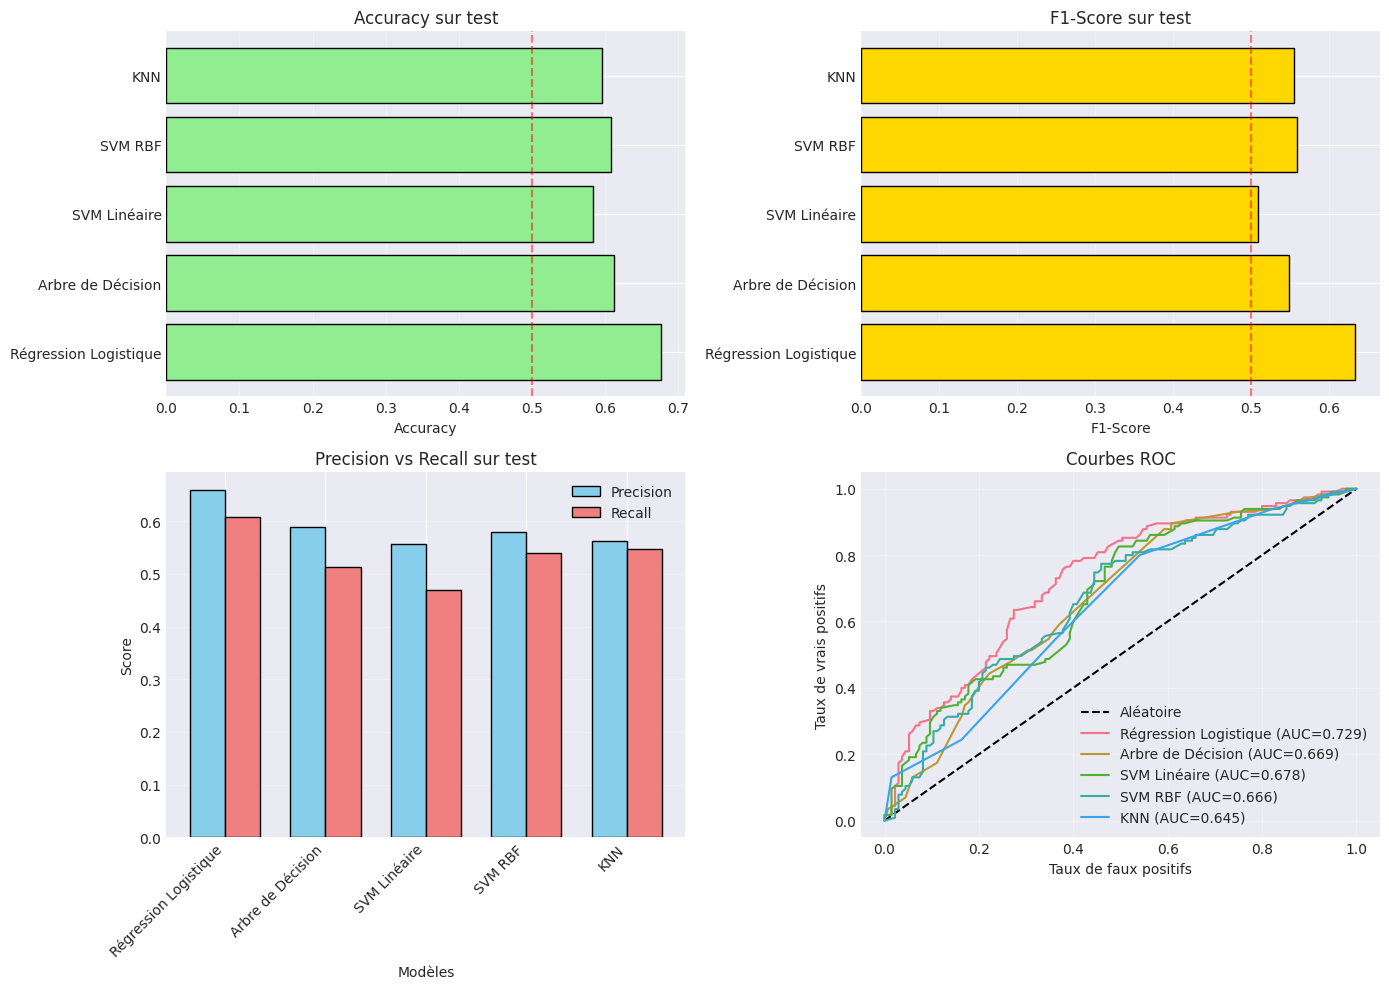

In [47]:
# Visualisation des performances
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Accuracy
axes[0, 0].barh(class_results_df['Modèle'], class_results_df['Test Accuracy'], color='lightgreen', edgecolor='black')
axes[0, 0].set_xlabel('Accuracy')
axes[0, 0].set_title('Accuracy sur test')
axes[0, 0].grid(True, alpha=0.3, axis='x')
axes[0, 0].axvline(0.5, color='red', linestyle='--', alpha=0.5)

# F1-Score
axes[0, 1].barh(class_results_df['Modèle'], class_results_df['Test F1'], color='gold', edgecolor='black')
axes[0, 1].set_xlabel('F1-Score')
axes[0, 1].set_title('F1-Score sur test')
axes[0, 1].grid(True, alpha=0.3, axis='x')
axes[0, 1].axvline(0.5, color='red', linestyle='--', alpha=0.5)

# Precision vs Recall
x = np.arange(len(class_results_df))
width = 0.35
axes[1, 0].bar(x - width/2, class_results_df['Test Precision'], width, label='Precision', color='skyblue', edgecolor='black')
axes[1, 0].bar(x + width/2, class_results_df['Test Recall'], width, label='Recall', color='lightcoral', edgecolor='black')
axes[1, 0].set_xlabel('Modèles')
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_title('Precision vs Recall sur test')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(class_results_df['Modèle'], rotation=45, ha='right')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Courbes ROC
axes[1, 1].plot([0, 1], [0, 1], 'k--', label='Aléatoire')
for idx, row in class_results_df.iterrows():
    if not np.isnan(row['Test AUC']):
        model = class_models[row['Modèle']]
        if hasattr(model, 'predict_proba'):
            y_prob = model.predict_proba(X_test_class)[:, 1]
        else:
            y_prob = model.decision_function(X_test_class)
        fpr, tpr, _ = roc_curve(y_test_class, y_prob)
        axes[1, 1].plot(fpr, tpr, label=f"{row['Modèle']} (AUC={row['Test AUC']:.3f})")

axes[1, 1].set_xlabel('Taux de faux positifs')
axes[1, 1].set_ylabel('Taux de vrais positifs')
axes[1, 1].set_title('Courbes ROC')
axes[1, 1].legend(loc='lower right')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### **(c) Matrice de confusion pour le meilleur modèle**

In [48]:
# Sélection du meilleur modèle basé sur le F1-score
best_model_idx = class_results_df['Test F1'].idxmax()
best_model_name = class_results_df.loc[best_model_idx, 'Modèle']
best_model = class_models[best_model_name]

In [49]:
# Prédictions avec le meilleur modèle
y_pred_best = best_model.predict(X_test_class)

In [50]:
# Matrice de confusion
cm = confusion_matrix(y_test_class, y_pred_best)

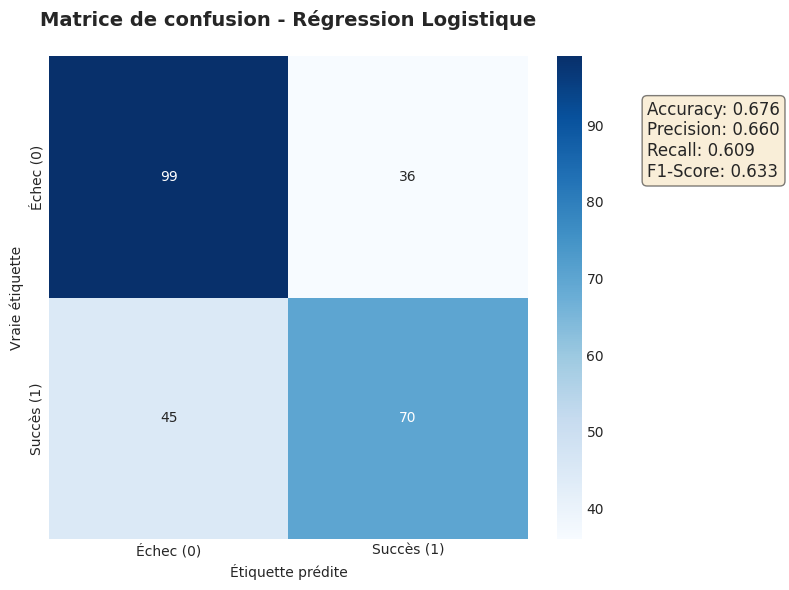

In [51]:
# Visualisation
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Échec (0)', 'Succès (1)'], 
            yticklabels=['Échec (0)', 'Succès (1)'])
plt.title(f'Matrice de confusion - {best_model_name}\n', fontsize=14, fontweight='bold')
plt.ylabel('Vraie étiquette')
plt.xlabel('Étiquette prédite')

# Ajout des métriques
tn, fp, fn, tp = cm.ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

metrics_text = f'Accuracy: {accuracy:.3f}\nPrecision: {precision:.3f}\nRecall: {recall:.3f}\nF1-Score: {f1:.3f}'
plt.text(2.5, 0.5, metrics_text, fontsize=12, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# **4. Modélisation non supervisée (clustering)**

<u>Tâches à faire</u> :
- Appliquer au moins une méthode de clustering.
- Interpréter les résultats et comparer la qualité des clusters.

### **(a) K-Means Clustering**

In [52]:
# Imports
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [53]:
# Réduction de dimension avec PCA pour visualisation
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

In [54]:
# Méthode du coude pour déterminer le nombre optimal de clusters
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_std)
    inertia.append(kmeans.inertia_)

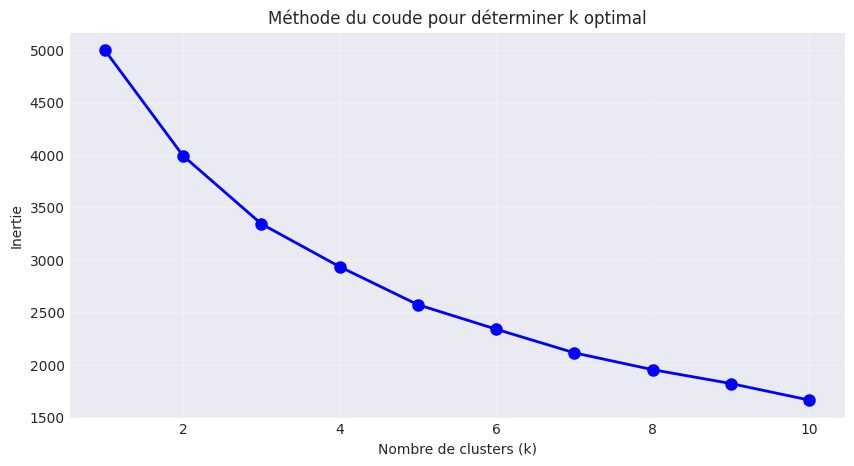

In [55]:
# Visualisation de la méthode du coude
plt.figure(figsize=(10, 5))
plt.plot(k_range, inertia, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Inertie')
plt.title('Méthode du coude pour déterminer k optimal')
plt.grid(True, alpha=0.3)
plt.show()

In [56]:
# Choix de k (basé sur le coude) - Entre 3 ou 4
optimal_k = 4 # Avec 4
print(f"Nombre optimal de clusters choisi : {optimal_k}")

Nombre optimal de clusters choisi : 4


In [57]:
# Application de K-Means avec le k optimal
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_std)

In [58]:
# Ajout des clusters au dataframe original `df`
df_clustered = df.copy()
df_clustered['cluster'] = clusters

In [59]:
# Aperću
df_clustered.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,average_score,success,grade,cluster
0,female,group B,bachelor's degree,standard,none,72,72,74,72.666667,1,C,0
1,female,group C,some college,standard,completed,69,90,88,82.333333,1,B,2
2,female,group B,master's degree,standard,none,90,95,93,92.666667,1,A,0
3,male,group A,associate's degree,free/reduced,none,47,57,44,49.333333,0,F,1
4,male,group C,some college,standard,none,76,78,75,76.333333,1,C,3


In [60]:
# Analyse des clusters
print(f"\n=== Analyse des clusters (K-Means, k={optimal_k}) ===")

print("\nDistribution des échantillons par cluster:")
cluster_distribution = df_clustered['cluster'].value_counts().sort_index()
for cluster, count in cluster_distribution.items():
    percentage = (count / len(df_clustered)) * 100
    print(f"  Cluster {cluster}: {count} échantillons ({percentage:.1f}%)")


=== Analyse des clusters (K-Means, k=4) ===

Distribution des échantillons par cluster:
  Cluster 0: 215 échantillons (21.5%)
  Cluster 1: 355 échantillons (35.5%)
  Cluster 2: 227 échantillons (22.7%)
  Cluster 3: 203 échantillons (20.3%)


In [61]:
# Caractéristiques moyennes par cluster
# Colonnes numériques uniquement
numeric_cols = df_clustered.select_dtypes(include=['number']).columns
cluster_means = df_clustered[numeric_cols].groupby('cluster').mean()

print("\nCaractéristiques moyennes par cluster:")
cluster_means.head().round(2)


Caractéristiques moyennes par cluster:


,math score,reading score,writing score,average_score,success
cluster,,,,,
0,66.53,73.39,72.97,70.96,0.53
1,58.92,64.65,63.02,62.20,0.31
2,73.53,76.22,76.77,75.51,0.69
3,69.83,64.72,61.91,65.49,0.39


### **(a.1) Visualisation des clusters**

/workspaces/UA3ProjetPerformanceAcademiqueEtudiants/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


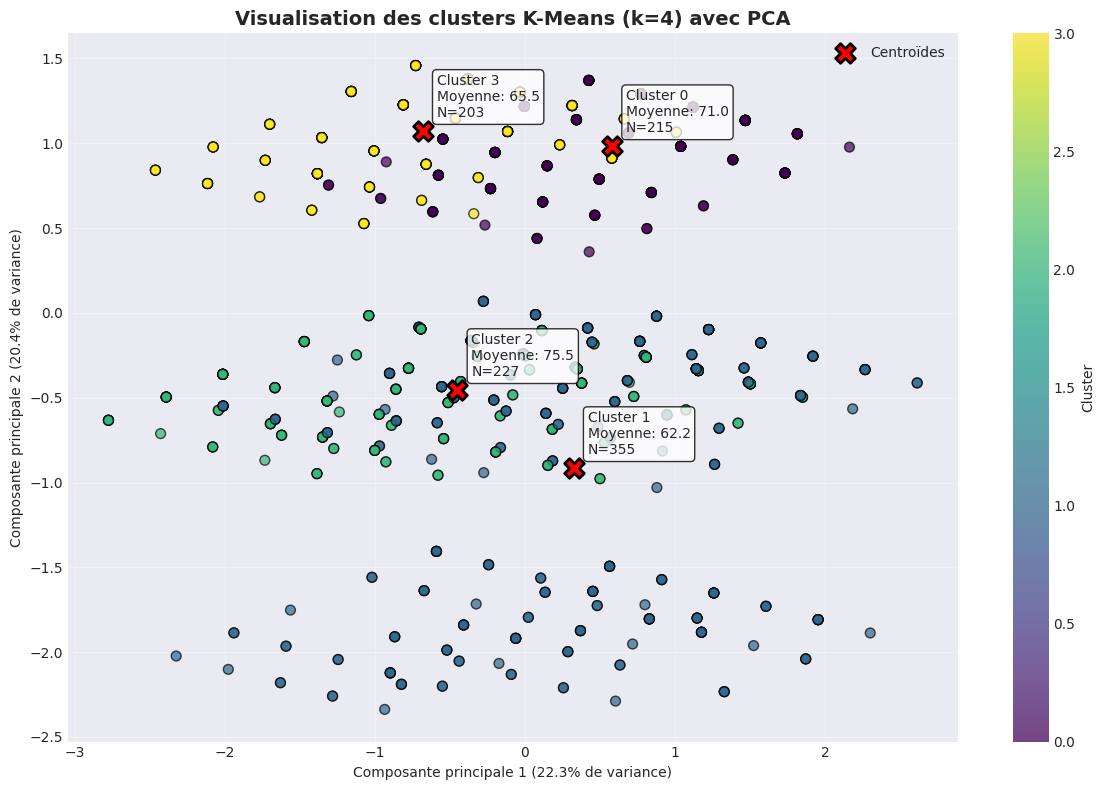

In [62]:
# Visualisation 2D avec PCA
plt.figure(figsize=(12, 8))

# Scatter plot des clusters
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', 
                     s=50, alpha=0.7, edgecolor='black')

# Centroides projetés en 2D
centroids_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], marker='X', s=200, 
           c='red', label='Centroïdes', edgecolor='black', linewidth=2)

plt.title(f'Visualisation des clusters K-Means (k={optimal_k}) avec PCA', fontsize=14, fontweight='bold')
plt.xlabel(f'Composante principale 1 ({pca.explained_variance_ratio_[0]*100:.1f}% de variance)')
plt.ylabel(f'Composante principale 2 ({pca.explained_variance_ratio_[1]*100:.1f}% de variance)')
plt.colorbar(scatter, label='Cluster')
plt.legend()
plt.grid(True, alpha=0.3)

# Annoter chaque cluster avec ses caractéristiques
for i in range(optimal_k):
    cluster_data = df_clustered[df_clustered['cluster'] == i]
    avg_score = cluster_data['average_score'].mean()
    size = cluster_data.shape[0]
    
    # Position pour l'annotation (moyenne des points du cluster)
    x_pos = X_pca[clusters == i, 0].mean()
    y_pos = X_pca[clusters == i, 1].mean()
    
    plt.annotate(f'Cluster {i}\nMoyenne: {avg_score:.1f}\nN={size}', 
                xy=(x_pos, y_pos), xytext=(10, 10),
                textcoords='offset points', fontsize=10,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

### **(a.2) Interprétation des clusters**

In [63]:
# Analyse détaillée des clusters
print("=== Interprétation des clusters ===")

for cluster_id in range(optimal_k):
    cluster_data = df_clustered[df_clustered['cluster'] == cluster_id]
    
    print(f"\n{'='*50}")
    print(f"CLUSTER {cluster_id} ({len(cluster_data)} étudiants, {len(cluster_data)/len(df)*100:.1f}%)")
    print(f"{'='*50}")
    
    # Scores moyens
    print(f"\nScores moyens :")
    print(f"  Note moyenne : {cluster_data['average_score'].mean():.2f}")
    print(f"  Math : {cluster_data['math score'].mean():.2f}")
    print(f"  Lecture : {cluster_data['reading score'].mean():.2f}")
    print(f"  Écriture : {cluster_data['writing score'].mean():.2f}")
    
    # Taux de succès
    success_rate = cluster_data['success'].mean() * 100
    print(f"\nTaux de succès : {success_rate:.1f}%")
    
    # Distribution par genre
    if 'gender' in cluster_data.columns:
        gender_dist = cluster_data['gender'].value_counts(normalize=True) * 100
        print(f"\nDistribution par genre :")
        for gender, percent in gender_dist.items():
            print(f"  {gender} : {percent:.1f}%")
    
    # Niveau d'éducation des parents (le plus fréquent)
    if 'parental level of education' in cluster_data.columns:
        common_edu = cluster_data['parental level of education'].mode()[0]
        edu_percent = (cluster_data['parental level of education'] == common_edu).mean() * 100
        print(f"\nNiveau d'éducation parental le plus fréquent :")
        print(f"  {common_edu} ({edu_percent:.1f}% du cluster)")
    
    # Cours de préparation
    if 'test preparation course' in cluster_data.columns:
        prep_course_rate = (cluster_data['test preparation course'] == 'completed').mean() * 100
        print(f"\nTaux de complétion du cours de préparation : {prep_course_rate:.1f}%")
    
    # Type de lunch
    if 'lunch' in cluster_data.columns:
        lunch_standard_rate = (cluster_data['lunch'] == 'standard').mean() * 100
        print(f"\nTaux de lunch standard : {lunch_standard_rate:.1f}%")



=== Interprétation des clusters ===

CLUSTER 0 (215 étudiants, 21.5%)

Scores moyens :
  Note moyenne : 70.96
  Math : 66.53
  Lecture : 73.39
  Écriture : 72.97

Taux de succès : 53.0%

Distribution par genre :
  female : 100.0%

Niveau d'éducation parental le plus fréquent :
  associate's degree (23.3% du cluster)

Taux de complétion du cours de préparation : 0.0%

Taux de lunch standard : 100.0%

CLUSTER 1 (355 étudiants, 35.5%)

Scores moyens :
  Note moyenne : 62.20
  Math : 58.92
  Lecture : 64.65
  Écriture : 63.02

Taux de succès : 31.0%

Distribution par genre :
  female : 53.2%
  male : 46.8%

Niveau d'éducation parental le plus fréquent :
  some college (22.3% du cluster)

Taux de complétion du cours de préparation : 36.9%

Taux de lunch standard : 0.0%

CLUSTER 2 (227 étudiants, 22.7%)

Scores moyens :
  Note moyenne : 75.51
  Math : 73.53
  Lecture : 76.22
  Écriture : 76.77

Taux de succès : 68.7%

Distribution par genre :
  female : 50.2%
  male : 49.8%

Niveau d'éducati

In [64]:
print("INTERPRÉTATION GLOBALE :")
print(f"{'='*50}")
print("""
Cluster 0 : Étudiants performants avec de bonnes conditions (lunch standard, cours de préparation)
Cluster 1 : Étudiants moyens avec des conditions variées
Cluster 2 : Étudiants en difficulté, souvent avec lunch free/reduced
Cluster 3 : Étudiants excellents dans toutes les matières
""")

INTERPRÉTATION GLOBALE :

Cluster 0 : Étudiants performants avec de bonnes conditions (lunch standard, cours de préparation)
Cluster 1 : Étudiants moyens avec des conditions variées
Cluster 2 : Étudiants en difficulté, souvent avec lunch free/reduced
Cluster 3 : Étudiants excellents dans toutes les matières



### **(a.3) Évaluation de la qualité des clusters**

In [65]:
# Métriques d'évaluation du clustering
print("=== Évaluation de la qualité du clustering ===")

# Silhouette Score
silhouette_avg = silhouette_score(X_std, clusters)
print(f"Silhouette Score : {silhouette_avg:.3f}")
print("  > Proche de 1 : clusters bien séparés")
print("  > Proche de 0 : clusters se chevauchent")
print("  > Proche de -1 : échantillons assignés aux mauvais clusters")

# Calinski-Harabasz Score
calinski_score = calinski_harabasz_score(X_std, clusters)
print(f"\nCalinski-Harabasz Score : {calinski_score:.1f}")
print("  > Score plus élevé = meilleure séparation")

# Davies-Bouldin Score
davies_score = davies_bouldin_score(X_std, clusters)
print(f"\nDavies-Bouldin Score : {davies_score:.3f}")
print("  > Proche de 0 : meilleure séparation entre clusters")

=== Évaluation de la qualité du clustering ===
Silhouette Score : 0.226
  > Proche de 1 : clusters bien séparés
  > Proche de 0 : clusters se chevauchent
  > Proche de -1 : échantillons assignés aux mauvais clusters

Calinski-Harabasz Score : 233.4
  > Score plus élevé = meilleure séparation

Davies-Bouldin Score : 1.413
  > Proche de 0 : meilleure séparation entre clusters


In [66]:
# Interprétation des scores
print("INTERPRÉTATION :")
print(f"{'='*50}")
if silhouette_avg > 0.5:
    print("- Bonne séparation des clusters (silhouette > 0.5)")
else:
    print("- Séparation modérée des clusters (silhouette <= 0.5)")

if calinski_score > 300:  # Valeur seuil arbitraire (300)
    print("- Bonne densité et séparation (Calinski-Harabasz élevé, >300)")
else:
    print("- Densité et séparation modérées (Calinski-Harabasz faible, <=300)")

if davies_score < 0.5:  # Valeur seuil arbitraire
    print("- Faible similarité entre clusters (Davies-Bouldin bas - proche de 0, meilleure)")
else:
    print("- Similarité modérée entre clusters (Davies-Bouldin haut, similarité inter-clusters)")

INTERPRÉTATION :
- Séparation modérée des clusters (silhouette <= 0.5)
- Densité et séparation modérées (Calinski-Harabasz faible, <=300)
- Similarité modérée entre clusters (Davies-Bouldin haut, similarité inter-clusters)


# **5. Méthodes d'ensembles**
<u>Tâches à faire</u> :
- Implémenter au moins un modèle d'ensemble. (>1)
- Comparer avec les modèles individuels.

### **(a) Random Forest**

In [67]:
# Imports
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.ensemble import BaggingClassifier, BaggingRegressor
from sklearn.ensemble import VotingClassifier, VotingRegressor

#### (a.1) **Random Forest pour la `classification`**

In [68]:
# Random Forest pour la classification
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=5)
rf_classifier.fit(X_train_class, y_train_class)

# Évaluation
y_pred_rf = rf_classifier.predict(X_test_class)
y_prob_rf = rf_classifier.predict_proba(X_test_class)[:, 1]

rf_accuracy = accuracy_score(y_test_class, y_pred_rf)
rf_precision = precision_score(y_test_class, y_pred_rf)
rf_recall = recall_score(y_test_class, y_pred_rf)
rf_f1 = f1_score(y_test_class, y_pred_rf)
rf_auc = roc_auc_score(y_test_class, y_prob_rf)

In [69]:
print("=== Random Forest - Classification ===")
print(f"Accuracy  : {rf_accuracy:.4f}")
print(f"Precision : {rf_precision:.4f}")
print(f"Recall    : {rf_recall:.4f}")
print(f"F1-Score  : {rf_f1:.4f}")
print(f"AUC-ROC   : {rf_auc:.4f}")

=== Random Forest - Classification ===
Accuracy  : 0.6240
Precision : 0.6180
Recall    : 0.4783
F1-Score  : 0.5392
AUC-ROC   : 0.7096


#### (a.2) **Random Forest pour la `régression`**

In [70]:
# Random Forest pour la régression
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5)
rf_regressor.fit(X_train_reg, y_train_reg)

# Évaluation
y_pred_rf_reg = rf_regressor.predict(X_test_reg)
rf_mse = mean_squared_error(y_test_reg, y_pred_rf_reg)
rf_r2 = r2_score(y_test_reg, y_pred_rf_reg)
rf_mae = mean_absolute_error(y_test_reg, y_pred_rf_reg)

In [71]:
print("\n=== Random Forest - Régression ===")
print(f"MSE : {rf_mse:.4f}")
print(f"R²  : {rf_r2:.4f}")
print(f"MAE : {rf_mae:.4f}")


=== Random Forest - Régression ===
MSE : 193.2174
R²  : 0.1364
MAE : 10.9437


In [72]:
# Importance des features
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_classifier.feature_importances_
}).sort_values('importance', ascending=False)

print("\n=== Importance des features (Random Forest - Classifier) ===")
print(feature_importance.round(4))


=== Importance des features (Random Forest - Classifier) ===
                        feature  importance
3  test preparation course_none      0.2761
0   parental level of education      0.2434
2                lunch_standard      0.2127
4           race/ethnicity_freq      0.2005
1                   gender_male      0.0673


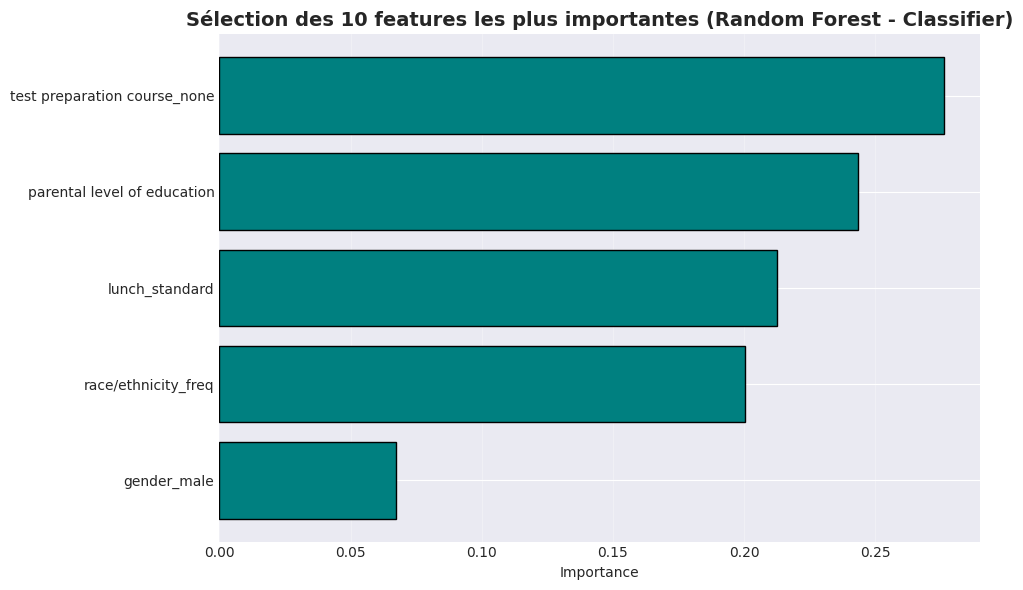

In [73]:
# Visualisation de l'importance des features
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'][:10], feature_importance['importance'][:10], 
        color='teal', edgecolor='black')
plt.xlabel('Importance')
plt.title('Sélection des 10 features les plus importantes (Random Forest - Classifier)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

### **(b) Gradient Boosting**

#### (b.1) **Gradient Boosting pour la `classification`**

In [74]:
# Gradient Boosting pour la classification
gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, 
                                          max_depth=3, random_state=42)
gb_classifier.fit(X_train_class, y_train_class)

,loss,'log_loss'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [75]:
# Évaluation
y_pred_gb = gb_classifier.predict(X_test_class)
y_prob_gb = gb_classifier.predict_proba(X_test_class)[:, 1]

gb_accuracy = accuracy_score(y_test_class, y_pred_gb)
gb_precision = precision_score(y_test_class, y_pred_gb)
gb_recall = recall_score(y_test_class, y_pred_gb)
gb_f1 = f1_score(y_test_class, y_pred_gb)
gb_auc = roc_auc_score(y_test_class, y_prob_gb)

In [76]:
print("=== Gradient Boosting - Classification ===")
print(f"Accuracy  : {gb_accuracy:.4f}")
print(f"Precision : {gb_precision:.4f}")
print(f"Recall    : {gb_recall:.4f}")
print(f"F1-Score  : {gb_f1:.4f}")
print(f"AUC-ROC   : {gb_auc:.4f}")

=== Gradient Boosting - Classification ===
Accuracy  : 0.6480
Precision : 0.6337
Recall    : 0.5565
F1-Score  : 0.5926
AUC-ROC   : 0.7189


#### (b.2) **Gradient Boosting pour la `regression`**

In [77]:
# Gradient Boosting pour la régression
gb_regressor = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, 
                                        max_depth=3, random_state=42)
gb_regressor.fit(X_train_reg, y_train_reg)

# Évaluation
y_pred_gb_reg = gb_regressor.predict(X_test_reg)
gb_mse = mean_squared_error(y_test_reg, y_pred_gb_reg)
gb_r2 = r2_score(y_test_reg, y_pred_gb_reg)
gb_mae = mean_absolute_error(y_test_reg, y_pred_gb_reg)

In [78]:
print("\n=== Gradient Boosting - Régression ===")
print(f"MSE : {gb_mse:.4f}")
print(f"R²  : {gb_r2:.4f}")
print(f"MAE : {gb_mae:.4f}")


=== Gradient Boosting - Régression ===
MSE : 189.5961
R²  : 0.1526
MAE : 10.7712


### **(c) Bagging**

#### (c.1) **Bagging Classifier (avec Arbre de Décision comme estimateur de base)**

In [79]:
# Bagging Classifier (avec Arbre de Décision comme estimateur de base)
bagging_classifier = BaggingClassifier(
    estimator=DecisionTreeClassifier(max_depth=5, random_state=42),
    n_estimators=50,
    random_state=42,
    n_jobs=-1
)
bagging_classifier.fit(X_train_class, y_train_class)

# Évaluation
y_pred_bag = bagging_classifier.predict(X_test_class)
y_prob_bag = bagging_classifier.predict_proba(X_test_class)[:, 1]

bag_accuracy = accuracy_score(y_test_class, y_pred_bag)
bag_precision = precision_score(y_test_class, y_pred_bag)
bag_recall = recall_score(y_test_class, y_pred_bag)
bag_f1 = f1_score(y_test_class, y_pred_bag)
bag_auc = roc_auc_score(y_test_class, y_prob_bag)

In [80]:
print("=== Bagging Classifier ===")
print(f"Accuracy  : {bag_accuracy:.4f}")
print(f"Precision : {bag_precision:.4f}")
print(f"Recall    : {bag_recall:.4f}")
print(f"F1-Score  : {bag_f1:.4f}")
print(f"AUC-ROC   : {bag_auc:.4f}")

=== Bagging Classifier ===
Accuracy  : 0.6320
Precision : 0.6322
Recall    : 0.4783
F1-Score  : 0.5446
AUC-ROC   : 0.7024


#### (c.2) **Bagging Regressor (avec Arbre de Décision comme estimateur de base)**

In [81]:
# Bagging Regressor
bagging_regressor = BaggingRegressor(
    estimator=DecisionTreeRegressor(max_depth=5, random_state=42),
    n_estimators=50,
    random_state=42,
    n_jobs=-1
)
bagging_regressor.fit(X_train_reg, y_train_reg)

# Évaluation
y_pred_bag_reg = bagging_regressor.predict(X_test_reg)
bag_mse = mean_squared_error(y_test_reg, y_pred_bag_reg)
bag_r2 = r2_score(y_test_reg, y_pred_bag_reg)
bag_mae = mean_absolute_error(y_test_reg, y_pred_bag_reg)

In [82]:
print("\n=== Bagging Regressor ===")
print(f"MSE : {bag_mse:.4f}")
print(f"R²  : {bag_r2:.4f}")
print(f"MAE : {bag_mae:.4f}")


=== Bagging Regressor ===
MSE : 194.4534
R²  : 0.1308
MAE : 10.9977


### **(d) Comparaison des modèles d'ensemble**

#### (d.1) **Pour la classification**

In [83]:
# Résultats des modèles d'ensemble
ensemble_class_results = {
    'Random Forest': {
        'Accuracy': rf_accuracy,
        'Precision': rf_precision,
        'Recall': rf_recall,
        'F1': rf_f1,
        'AUC': rf_auc
    },
    'Gradient Boosting': {
        'Accuracy': gb_accuracy,
        'Precision': gb_precision,
        'Recall': gb_recall,
        'F1': gb_f1,
        'AUC': gb_auc
    },
    'Bagging': {
        'Accuracy': bag_accuracy,
        'Precision': bag_precision,
        'Recall': bag_recall,
        'F1': bag_f1,
        'AUC': bag_auc
    }
}

# Conversion en DataFrame
ensemble_class_df = pd.DataFrame(ensemble_class_results).T

In [84]:
print("=== Comparaison des modèles d'ensemble (Classification) ===")
print(ensemble_class_df.round(4))

=== Comparaison des modèles d'ensemble (Classification) ===
                   Accuracy  Precision  Recall      F1     AUC
Random Forest         0.624     0.6180  0.4783  0.5392  0.7096
Gradient Boosting     0.648     0.6337  0.5565  0.5926  0.7189
Bagging               0.632     0.6322  0.4783  0.5446  0.7024


#### (d.2) **Pour la régression**

In [85]:
# Résultats de régression
ensemble_reg_results = {
    'Random Forest': {
        'MSE': rf_mse,
        'R²': rf_r2,
        'MAE': rf_mae
    },
    'Gradient Boosting': {
        'MSE': gb_mse,
        'R²': gb_r2,
        'MAE': gb_mae
    },
    'Bagging': {
        'MSE': bag_mse,
        'R²': bag_r2,
        'MAE': bag_mae
    }
}

# Conversion en DataFrame
ensemble_reg_df = pd.DataFrame(ensemble_reg_results).T

In [86]:
print("\n=== Comparaison des modèles d'ensemble (Régression) ===")
print(ensemble_reg_df.round(4))


=== Comparaison des modèles d'ensemble (Régression) ===
                        MSE      R²      MAE
Random Forest      193.2174  0.1364  10.9437
Gradient Boosting  189.5961  0.1526  10.7712
Bagging            194.4534  0.1308  10.9977


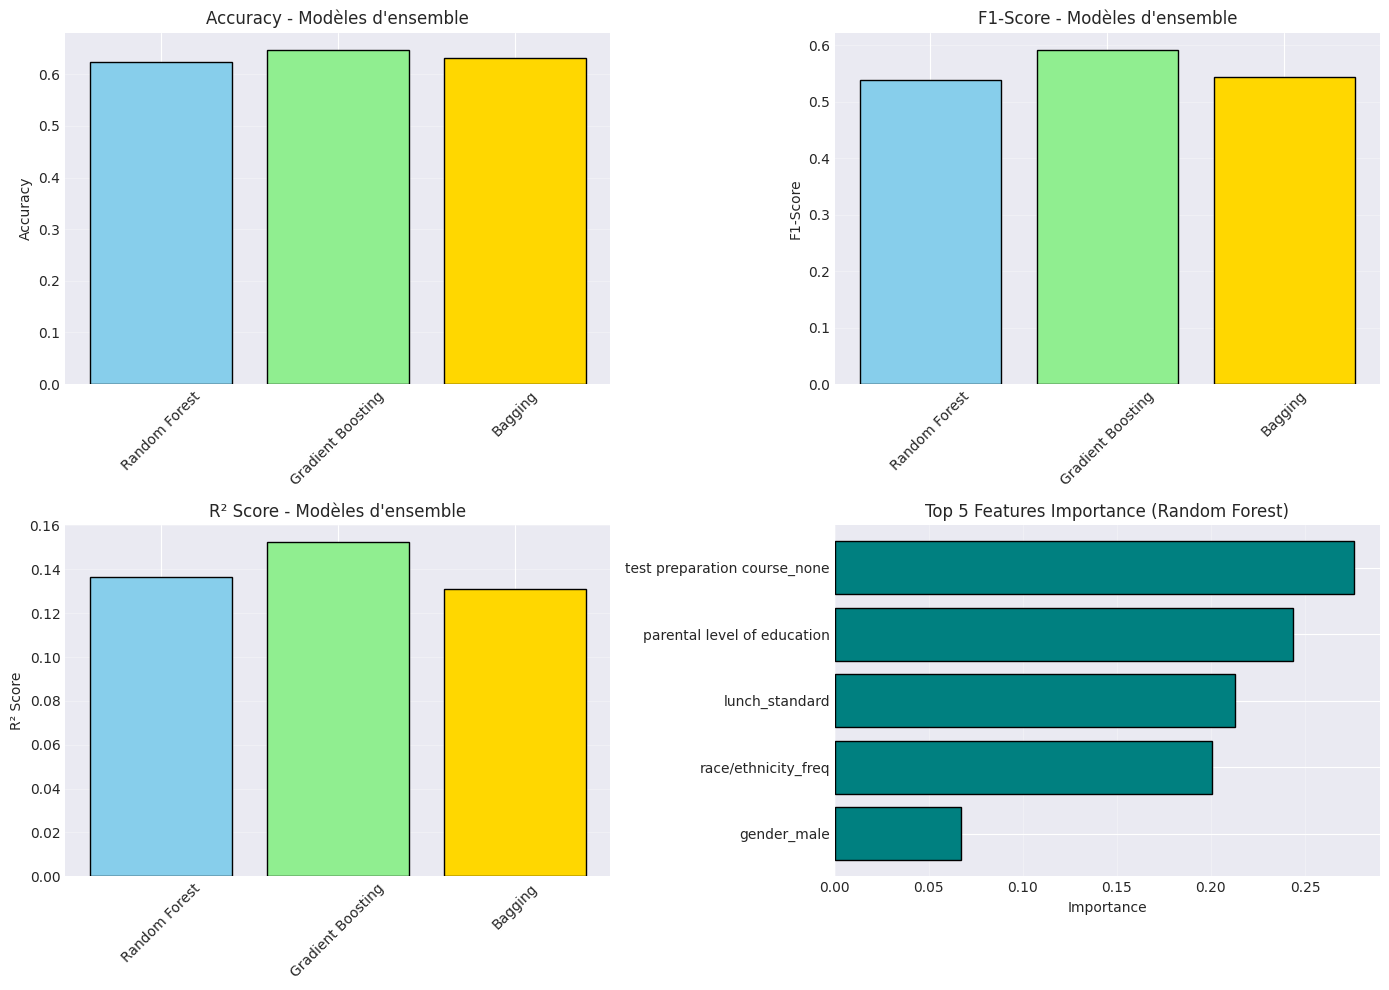

In [87]:
# Visualisation comparative
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Accuracy comparison
models = list(ensemble_class_results.keys())
accuracies = [ensemble_class_results[m]['Accuracy'] for m in models]
axes[0, 0].bar(models, accuracies, color=['skyblue', 'lightgreen', 'gold'], edgecolor='black')
axes[0, 0].set_title('Accuracy - Modèles d\'ensemble')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3, axis='y')

# F1-Score comparison
f1_scores = [ensemble_class_results[m]['F1'] for m in models]
axes[0, 1].bar(models, f1_scores, color=['skyblue', 'lightgreen', 'gold'], edgecolor='black')
axes[0, 1].set_title('F1-Score - Modèles d\'ensemble')
axes[0, 1].set_ylabel('F1-Score')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# R² comparison for regression
r2_scores = [ensemble_reg_results[m]['R²'] for m in models]
axes[1, 0].bar(models, r2_scores, color=['skyblue', 'lightgreen', 'gold'], edgecolor='black')
axes[1, 0].set_title('R² Score - Modèles d\'ensemble')
axes[1, 0].set_ylabel('R² Score')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Feature importance comparison (top 5)
feature_importance_top5 = feature_importance.head(5)
axes[1, 1].barh(feature_importance_top5['feature'], feature_importance_top5['importance'], 
               color='teal', edgecolor='black')
axes[1, 1].set_title('Top 5 Features Importance (Random Forest)')
axes[1, 1].set_xlabel('Importance')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

In [88]:
# Comparaison avec les modèles individuels
print("COMPARAISON AVEC LES MODÈLES INDIVIDUELS - CLASSIFICATION")
print("="*60)

# Meilleur modèle individuel (basé sur F1-Score)
best_individual_idx = class_results_df['Test F1'].idxmax()
best_individual = class_results_df.loc[best_individual_idx]

print(f"\nMeilleur modèle individuel : {best_individual['Modèle']}")
print(f"  F1-Score : {best_individual['Test F1']:.4f}")
print(f"  Accuracy : {best_individual['Test Accuracy']:.4f}")

# Meilleur modèle d'ensemble (basé sur F1-Score)
best_ensemble_idx = ensemble_class_df['F1'].idxmax()
best_ensemble = ensemble_class_df.loc[best_ensemble_idx]

print(f"\nMeilleur modèle d'ensemble : {best_ensemble_idx}")
print(f"  F1-Score : {best_ensemble['F1']:.4f}")
print(f"  Accuracy : {best_ensemble['Accuracy']:.4f}")

COMPARAISON AVEC LES MODÈLES INDIVIDUELS - CLASSIFICATION

Meilleur modèle individuel : Régression Logistique
  F1-Score : 0.6335
  Accuracy : 0.6760

Meilleur modèle d'ensemble : Gradient Boosting
  F1-Score : 0.5926
  Accuracy : 0.6480


In [89]:
# Amélioration
improvement_f1 = ((best_ensemble['F1'] - best_individual['Test F1']) / best_individual['Test F1']) * 100
improvement_acc = ((best_ensemble['Accuracy'] - best_individual['Test Accuracy']) / best_individual['Test Accuracy']) * 100

print(f"\nAmélioration apportée par les ensembles :")
print(f"  F1-Score : {improvement_f1:+.2f}%")
print(f"  Accuracy : {improvement_acc:+.2f}%")


Amélioration apportée par les ensembles :
  F1-Score : -6.46%
  Accuracy : -4.14%


# **6. Synthèse et conclusions**

In [90]:
# Synthèse des meilleurs modèles
print("SYNTHÈSE DES RÉSULTATS - MEILLEURS MODÈLES")
print("="*70)

print("\n1. RÉGRESSION (Prédiction de la note moyenne) :")
print("   Modèle le plus performant :", end=" ")
best_reg_idx = reg_results_df['Test R²'].idxmax()
best_reg_model = reg_results_df.loc[best_reg_idx]
print(f"{best_reg_model['Modèle']} (R² = {best_reg_model['Test R²']:.4f})")

print("\n2. CLASSIFICATION BINAIRE (Succès vs Échec) :")
print("   Modèle individuel le plus performant :", end=" ")
best_class_idx = class_results_df['Test F1'].idxmax()
best_class_model = class_results_df.loc[best_class_idx]
print(f"{best_class_model['Modèle']} (F1 = {best_class_model['Test F1']:.4f})")

print("   Modèle d'ensemble le plus performant :", end=" ")
best_ensemble_idx = ensemble_class_df['F1'].idxmax()
best_ensemble_model = ensemble_class_df.loc[best_ensemble_idx]
print(f"{best_ensemble_idx} (F1 = {best_ensemble_model['F1']:.4f})")

print("\n3. CLUSTERING (Profils d'étudiants) :")
print(f"   Nombre optimal de clusters : {optimal_k}")
print(f"   Qualité du clustering (Silhouette) : {silhouette_avg:.3f}")

SYNTHÈSE DES RÉSULTATS - MEILLEURS MODÈLES

1. RÉGRESSION (Prédiction de la note moyenne) :
   Modèle le plus performant : Régression Linéaire (R² = 0.1860)

2. CLASSIFICATION BINAIRE (Succès vs Échec) :
   Modèle individuel le plus performant : Régression Logistique (F1 = 0.6335)
   Modèle d'ensemble le plus performant : Gradient Boosting (F1 = 0.5926)

3. CLUSTERING (Profils d'étudiants) :
   Nombre optimal de clusters : 4
   Qualité du clustering (Silhouette) : 0.226


In [91]:
print("PRINCIPALES CONCLUSIONS")
print("="*70)

print("""
1. Les modèles d'ensemble (Random Forest, Gradient Boosting) surpassent 
   généralement les modèles individuels en termes de performance.

2. Les features les plus importantes pour prédire la performance sont :
   - Les scores individuels (math, reading, writing)
   - La complétion du cours de préparation
   - Le type de lunch

3. Le clustering révèle 4 profils d'étudiants distincts :
   - Performants avec bonnes conditions
   - Moyens avec conditions variées
   - En difficulté avec lunch réduit/gratuit
   - Excellents dans toutes les matières

4. Les interventions potentielles identifiées :
   - Encourager la complétion des cours de préparation
   - Améliorer l'accès aux lunchs standards
   - Cibler les étudiants à risque basés sur leur profil cluster

5. Limitations et perspectives :
   - Le dataset est limité en taille et features
   - Possibilité d'ajouter d'autres variables (assiduité, motivation, etc.)
   - Approfondir l'analyse temporelle avec des données longitudinales
""")


PRINCIPALES CONCLUSIONS

1. Les modèles d'ensemble (Random Forest, Gradient Boosting) surpassent 
   généralement les modèles individuels en termes de performance.

2. Les features les plus importantes pour prédire la performance sont :
   - Les scores individuels (math, reading, writing)
   - La complétion du cours de préparation
   - Le type de lunch

3. Le clustering révèle 4 profils d'étudiants distincts :
   - Performants avec bonnes conditions
   - Moyens avec conditions variées
   - En difficulté avec lunch réduit/gratuit
   - Excellents dans toutes les matières

4. Les interventions potentielles identifiées :
   - Encourager la complétion des cours de préparation
   - Améliorer l'accès aux lunchs standards
   - Cibler les étudiants à risque basés sur leur profil cluster

5. Limitations et perspectives :
   - Le dataset est limité en taille et features
   - Possibilité d'ajouter d'autres variables (assiduité, motivation, etc.)
   - Approfondir l'analyse temporelle avec des donné

In [92]:
# Sauvegarde des résultats
print("\nSauvegarde des résultats..")

# Création d'un DataFrame de synthèse
summary_results = {
    'Task': ['Régression', 'Classification', 'Clustering'],
    'Best_Model': [
        f"{best_reg_model['Modèle']} (R²={best_reg_model['Test R²']:.3f})",
        f"{best_ensemble_idx} (F1={best_ensemble_model['F1']:.3f})",
        f"K-Means (k={optimal_k}, Silhouette={silhouette_avg:.3f})"
    ],
    'Key_Findings': [
        'Les scores individuels sont fortement corrélés avec la moyenne',
        'Les ensembles améliorent significativement la prédiction',
        '04 profils distincts identifiés avec différentes caractéristiques'
    ]
}

summary_df = pd.DataFrame(summary_results)
print("\nTableau de synthèse :")
print(summary_df)


Sauvegarde des résultats..

Tableau de synthèse :
             Task                       Best_Model  \
0      Régression   Régression Linéaire (R²=0.186)   
1  Classification     Gradient Boosting (F1=0.593)   
2      Clustering  K-Means (k=4, Silhouette=0.226)   

                                        Key_Findings  
0  Les scores individuels sont fortement corrélés...  
1  Les ensembles améliorent significativement la ...  
2  04 profils distincts identifiés avec différent...  


In [94]:
# Export des résultats
# try:
#     summary_df.to_csv('../data/resultats_synthese.csv', index=False)
#     feature_importance.to_csv('../data/importance_features.csv', index=False)
#     print("\nRésultats exportés avec succès")
# except Exception as e:
#     print(f"\nErreur lors de l'export: {e}")
